In [1]:
# Setup for Google Colab
import sys
import subprocess
import os

# Install LightGlue and dependencies if on Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab - Installing dependencies...")
    subprocess.run(["pip", "install", "git+https://github.com/cvg/LightGlue.git"], check=True)
    subprocess.run(["pip", "install", "opencv-python-headless"], check=True)
    print("Dependencies installed!")
else:
    print("Running locally - assuming dependencies are installed via Poetry/Conda")

Running locally - assuming dependencies are installed via Poetry/Conda


In [2]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import glob
from pathlib import Path
import time
import torch

# LightGlue imports
from lightglue import SIFT
from lightglue.utils import load_image

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("All libraries imported successfully!")

Using device: cpu
All libraries imported successfully!


## 1. Load Reference Images

Loading all turtle images from the `data/initial_database` directory. Each image represents either the left or right side of a turtle's face.

In [3]:
# Set up paths
data_dir = Path("data/initial_database")
if not data_dir.exists():
    print(f"Warning: {data_dir} not found. Creating directory structure...")
    data_dir.mkdir(parents=True, exist_ok=True)

# Load all JPG images
image_paths = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.JPG"))
print(f"Found {len(image_paths)} images:")
for path in sorted(image_paths):
    print(f"  - {path.name}")

# Dictionary to store images and tensors
reference_images = {}
reference_tensors = {}

for img_path in image_paths:
    # Load for display purposes
    img = cv2.imread(str(img_path))
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        reference_images[img_path.stem] = img_rgb
        
        # Load as tensor for LightGlue - FIX: Ensure correct tensor shape
        try:
            img_tensor = load_image(str(img_path))
            
            # Debug: Print tensor shape
            print(f"Raw tensor shape for {img_path.name}: {img_tensor.shape}")
            
            # Ensure tensor is in correct format [1, C, H, W]
            if len(img_tensor.shape) == 3:  # [C, H, W] - add batch dimension
                img_tensor = img_tensor.unsqueeze(0)
            elif len(img_tensor.shape) == 2:  # [H, W] - add channel and batch
                img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)
            
            img_tensor = img_tensor.to(device)
            reference_tensors[img_path.stem] = img_tensor
            print(f"Loaded: {img_path.name} - Display shape: {img_rgb.shape}, Tensor shape: {img_tensor.shape}")
            
        except Exception as e:
            print(f"Failed to load tensor for {img_path.name}: {e}")
    else:
        print(f"Failed to load: {img_path.name}")

print(f"\nSuccessfully loaded {len(reference_images)} reference images")
print(f"Successfully loaded {len(reference_tensors)} reference tensors")

Found 10 images:
  - Crush L.jpg
  - Crush R.jpg
  - Donatello L.jpg
  - Donatello R.jpg
  - Leonardo L.jpg
  - Leonardo R.jpg
  - Michelangelo L.jpg
  - Michelangelo R.jpg
  - Rafael L.jpg
  - Rafael R.jpg
Raw tensor shape for Rafael L.jpg: torch.Size([3, 640, 480])
Loaded: Rafael L.jpg - Display shape: (640, 480, 3), Tensor shape: torch.Size([1, 3, 640, 480])
Raw tensor shape for Donatello L.jpg: torch.Size([3, 2448, 3264])
Loaded: Donatello L.jpg - Display shape: (2448, 3264, 3), Tensor shape: torch.Size([1, 3, 2448, 3264])
Raw tensor shape for Leonardo L.jpg: torch.Size([3, 640, 480])
Loaded: Leonardo L.jpg - Display shape: (640, 480, 3), Tensor shape: torch.Size([1, 3, 640, 480])
Raw tensor shape for Crush R.jpg: torch.Size([3, 640, 480])
Loaded: Crush R.jpg - Display shape: (640, 480, 3), Tensor shape: torch.Size([1, 3, 640, 480])
Raw tensor shape for Michelangelo L.jpg: torch.Size([3, 480, 640])
Loaded: Michelangelo L.jpg - Display shape: (480, 640, 3), Tensor shape: torch.Size(

## 2. Display Reference Images

Let's visualize all our reference turtle images to understand our dataset.

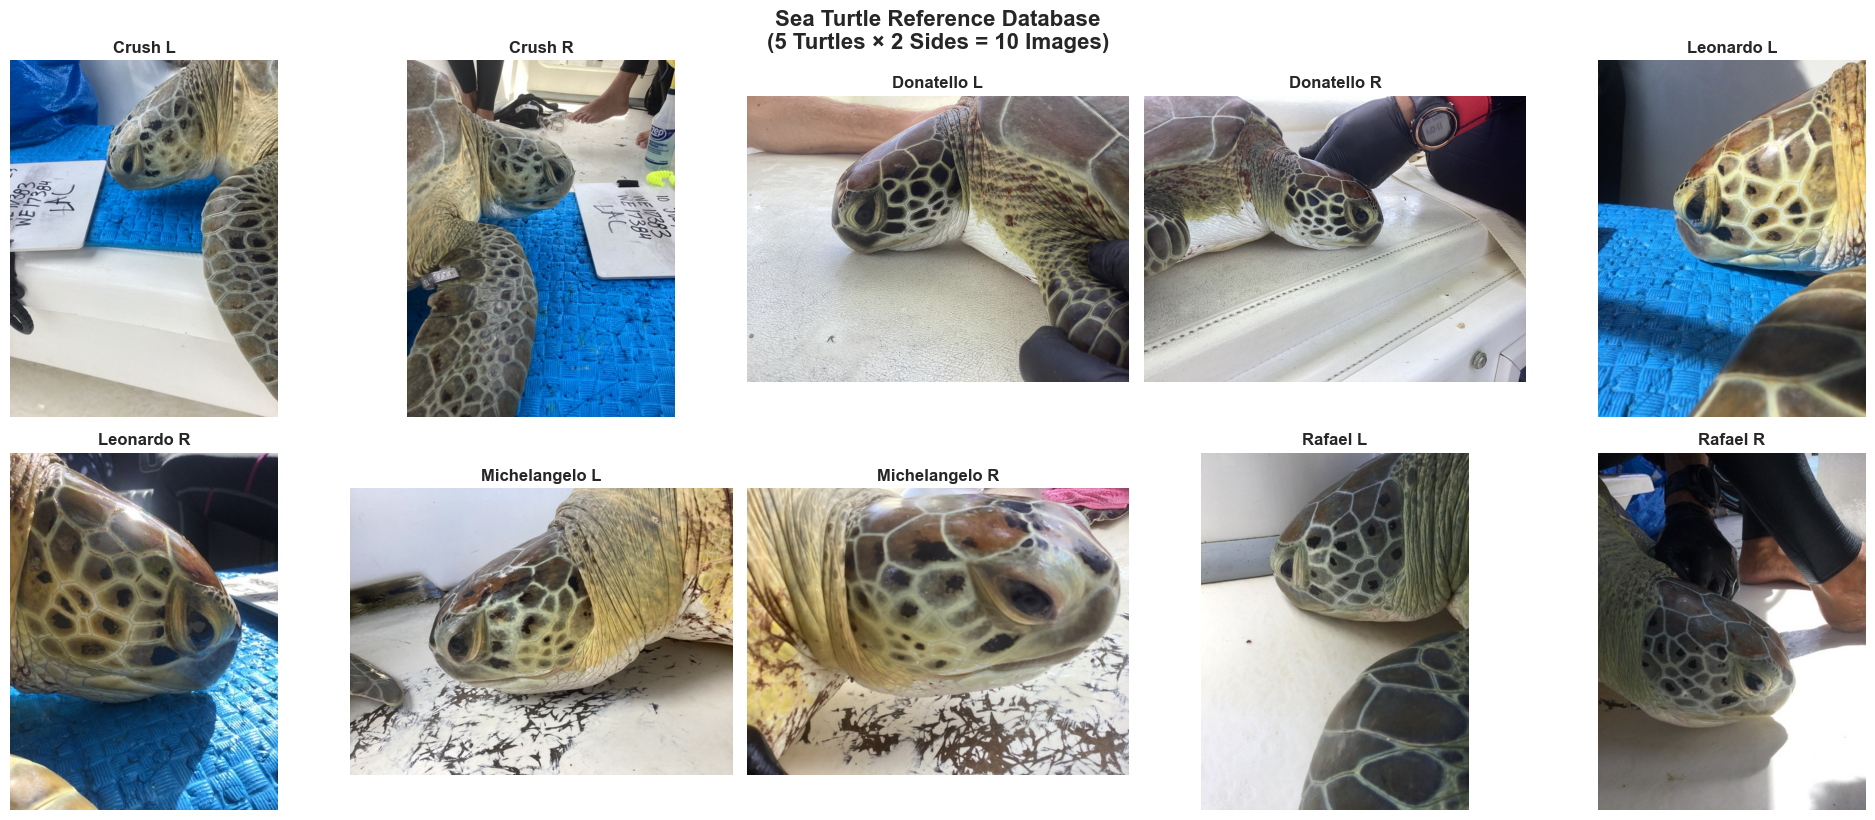

In [4]:
# Create a grid display of all reference images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (name, image) in enumerate(sorted(reference_images.items())):
    if idx < len(axes):
        axes[idx].imshow(image)
        axes[idx].set_title(name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(reference_images), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Sea Turtle Reference Database\n(5 Turtles × 2 Sides = 10 Images)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 3. Extract SIFT Keypoints

SIFT (Scale-Invariant Feature Transform) detects distinctive keypoints that are robust to scaling, rotation, and illumination changes - perfect for turtle facial recognition.

In [12]:
# Initialize LightGlue SIFT extractor
extractor = SIFT(max_num_keypoints=2048).eval().to(device)

# Dictionary to store keypoints and descriptors
reference_library = {}

print("Extracting SIFT keypoints using LightGlue...")
print("=" * 50)

for name, img_tensor in reference_tensors.items():
    # Extract features using LightGlue SIFT
    start_time = time.time()
    
    with torch.no_grad():
        features = extractor({'image': img_tensor})
    
    extraction_time = time.time() - start_time
    
    if features['keypoints'] is not None and len(features['keypoints'][0]) > 0:
        reference_library[name] = {
            'keypoints': features['keypoints'].cpu(),
            'descriptors': features['descriptors'].cpu(),
            'scales': features.get('scales', torch.ones(features['keypoints'].shape[0], features['keypoints'].shape[1])).cpu(),
            'oris': features.get('oris', torch.zeros(features['keypoints'].shape[0], features['keypoints'].shape[1])).cpu(),
            'image_shape': img_tensor.shape[-2:],  # (H, W)
            'num_keypoints': len(features['keypoints'][0]),
            'extraction_time': extraction_time
        }
        
        print(f"{name:20s} | {len(features['keypoints'][0]):4d} keypoints | {extraction_time:.3f}s")
    else:
        print(f"{name:20s} | Failed to extract keypoints!")
        reference_library[name] = None

print("=" * 50)
print(f"Successfully processed {len([k for k in reference_library.values() if k is not None])} images")

Extracting SIFT keypoints using LightGlue...
Rafael L             | 1806 keypoints | 0.530s
Donatello L          | 1533 keypoints | 4.201s
Leonardo L           | 1702 keypoints | 0.153s
Crush R              | 1635 keypoints | 0.065s
Michelangelo L       | 1700 keypoints | 0.090s
Michelangelo R       | 1655 keypoints | 0.077s
Rafael R             | 1743 keypoints | 0.068s
Donatello R          | 1625 keypoints | 3.609s
Leonardo R           | 1692 keypoints | 0.218s
Crush L              | 1713 keypoints | 0.086s
Successfully processed 10 images


## 4. Visualize SIFT Keypoints

Let's examine the keypoints detected on each turtle image to understand what features SIFT is capturing.

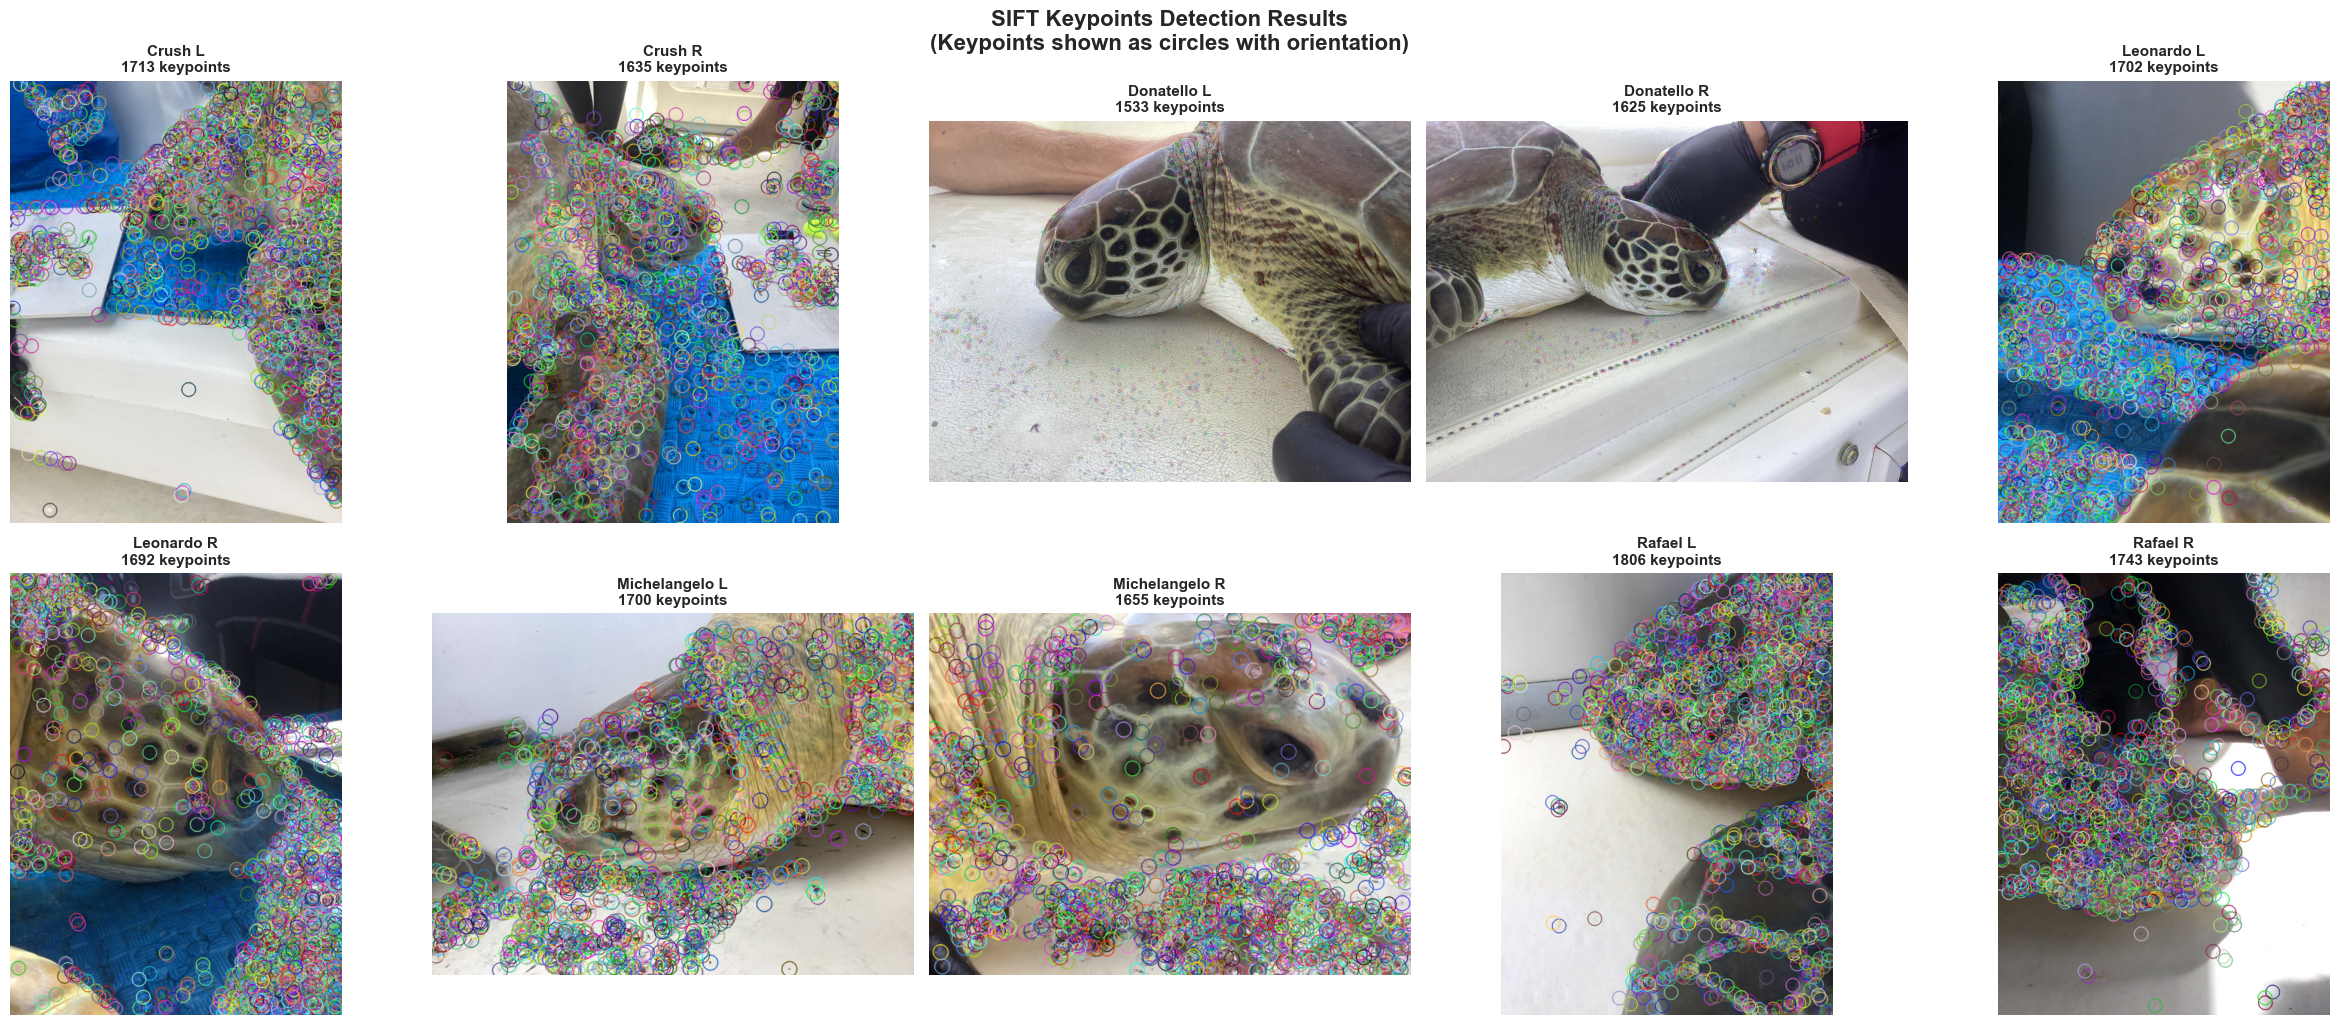

In [13]:
# Visualize keypoints for each turtle
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

def lightglue_to_opencv_keypoints(lg_keypoints):
    """Convert LightGlue keypoints to OpenCV format for visualization."""
    cv_keypoints = []
    for kp in lg_keypoints[0]:  # Remove batch dimension
        x, y = kp.cpu().numpy()
        cv_kp = cv2.KeyPoint(x=float(x), y=float(y), size=20)
        cv_keypoints.append(cv_kp)
    return cv_keypoints

for idx, (name, data) in enumerate(sorted(reference_library.items())):
    if idx < len(axes) and data is not None:
        # Convert LightGlue keypoints to OpenCV format for visualization
        cv_keypoints = lightglue_to_opencv_keypoints(data['keypoints'])
        
        # Draw keypoints on the image
        image = reference_images[name]
        img_with_kp = cv2.drawKeypoints(
            image, 
            cv_keypoints, 
            None, 
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        
        axes[idx].imshow(img_with_kp)
        axes[idx].set_title(f"{name}\n{data['num_keypoints']} keypoints", 
                           fontsize=11, fontweight='bold')
        axes[idx].axis('off')

# Hide unused subplots
for idx in range(len(reference_library), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('SIFT Keypoints Detection Results\n(Keypoints shown as circles with orientation)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

Donatello L and Donatello R seem off. Let's zoom in and check

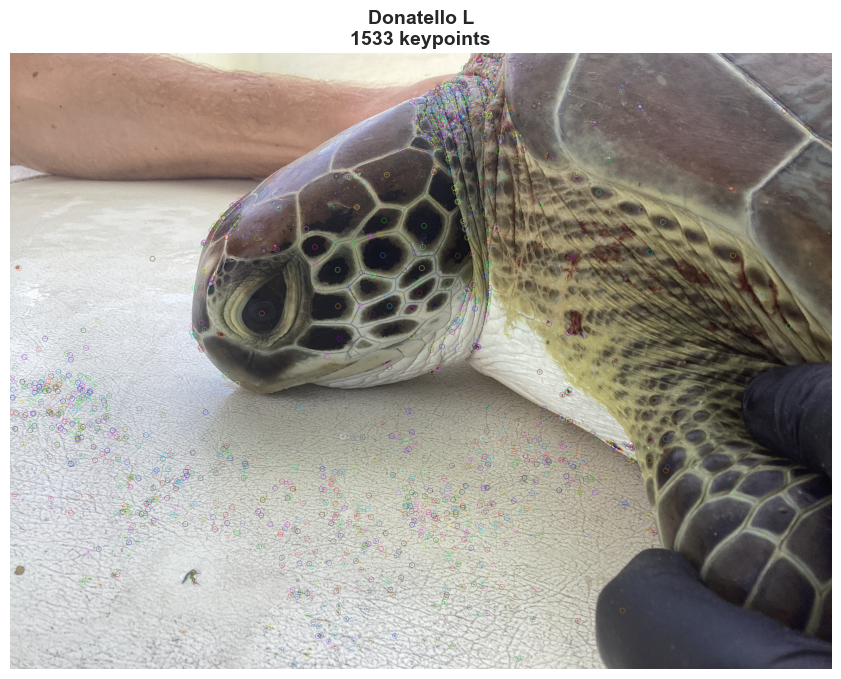

In [14]:
# Fix the Donatello L visualization
name = "Donatello L"
if name in reference_library and reference_library[name] is not None:
    # Get the data for this specific turtle
    data = reference_library[name]
    
    # Convert keypoints for this specific turtle
    cv_keypoints = lightglue_to_opencv_keypoints(data['keypoints'])
    
    # Draw keypoints on the image
    fig, ax = plt.subplots(figsize=(12, 8))
    image = reference_images[name]
    img_with_kp = cv2.drawKeypoints(
        image, 
        cv_keypoints, 
        None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    ax.imshow(img_with_kp)
    ax.set_title(f"{name}\n{data['num_keypoints']} keypoints", 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.show()
else:
    print(f"No keypoints found for {name}")

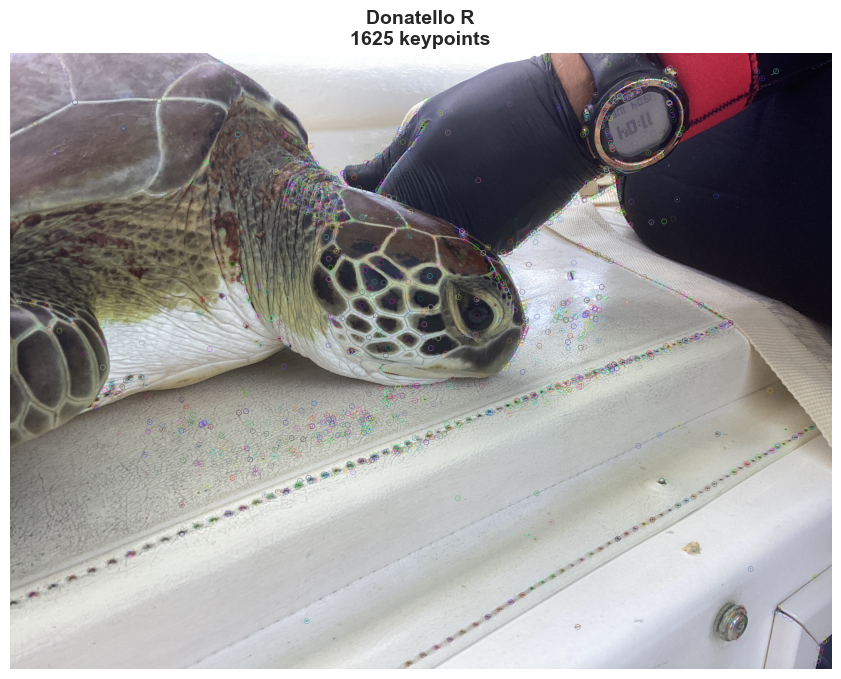

In [15]:
# Fix the Donatello R visualization
name = "Donatello R"
if name in reference_library and reference_library[name] is not None:
    # Get the data for this specific turtle
    data = reference_library[name]
    
    # Convert keypoints for this specific turtle
    cv_keypoints = lightglue_to_opencv_keypoints(data['keypoints'])
    
    # Draw keypoints on the image
    fig, ax = plt.subplots(figsize=(12, 8))
    image = reference_images[name]
    img_with_kp = cv2.drawKeypoints(
        image, 
        cv_keypoints, 
        None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    ax.imshow(img_with_kp)
    ax.set_title(f"{name}\n{data['num_keypoints']} keypoints", 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.show()
else:
    print(f"No keypoints found for {name}")

Ok they exist its just poor because of the background etc.

## 5. Keypoint Statistics

Let's analyze the distribution of keypoints across our turtle images.

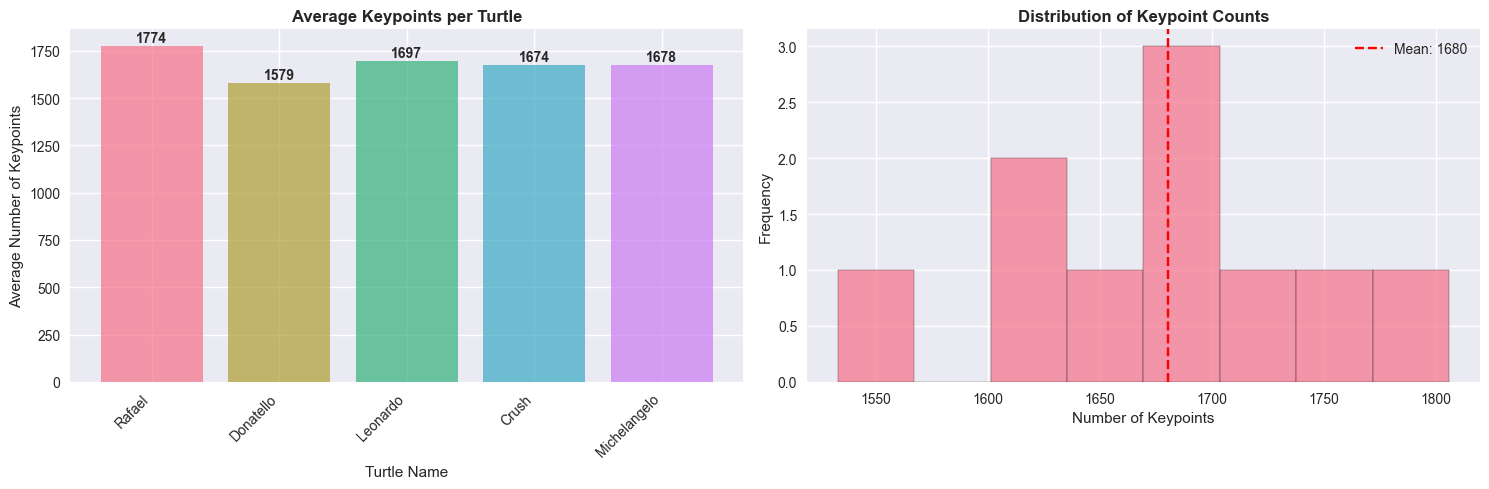


Keypoint Extraction Summary:
Total Images Processed: 10
Average Keypoints per Image: 1680.4
Standard Deviation: 70.2
Min Keypoints: 1533
Max Keypoints: 1806


In [16]:
# Gather statistics
keypoint_counts = []
turtle_names = []
sides = []

for name, data in reference_library.items():
    if data is not None:
        keypoint_counts.append(data['num_keypoints'])
        # Parse turtle name and side
        parts = name.split()
        turtle_names.append(parts[0])
        sides.append(parts[1] if len(parts) > 1 else 'Unknown')

# Create statistics visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Keypoint count by turtle
turtle_kp_data = {}
for turtle, count in zip(turtle_names, keypoint_counts):
    if turtle not in turtle_kp_data:
        turtle_kp_data[turtle] = []
    turtle_kp_data[turtle].append(count)

turtles = list(turtle_kp_data.keys())
avg_keypoints = [np.mean(turtle_kp_data[turtle]) for turtle in turtles]

bars1 = ax1.bar(turtles, avg_keypoints, alpha=0.7, color=sns.color_palette("husl", len(turtles)))
ax1.set_title('Average Keypoints per Turtle', fontweight='bold')
ax1.set_ylabel('Average Number of Keypoints')
ax1.set_xlabel('Turtle Name')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, value in zip(bars1, avg_keypoints):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

# Distribution histogram
ax2.hist(keypoint_counts, bins=8, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Keypoint Counts', fontweight='bold')
ax2.set_xlabel('Number of Keypoints')
ax2.set_ylabel('Frequency')
ax2.axvline(np.mean(keypoint_counts), color='red', linestyle='--', 
           label=f'Mean: {np.mean(keypoint_counts):.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nKeypoint Extraction Summary:")
print("=" * 40)
print(f"Total Images Processed: {len([d for d in reference_library.values() if d is not None])}")
print(f"Average Keypoints per Image: {np.mean(keypoint_counts):.1f}")
print(f"Standard Deviation: {np.std(keypoint_counts):.1f}")
print(f"Min Keypoints: {min(keypoint_counts)}")
print(f"Max Keypoints: {max(keypoint_counts)}")

## 6. Save Reference Library

Now we'll save the reference library to disk so it can be loaded quickly by the inference notebook.

In [17]:
# Prepare data for serialization - LightGlue tensors are already serializable
serializable_library = {}

for name, data in reference_library.items():
    if data is not None:
        # LightGlue features are already in tensor format and can be saved directly
        serializable_library[name] = {
            'keypoints': data['keypoints'],  # Already CPU tensors
            'descriptors': data['descriptors'],  # Already CPU tensors
            'scales': data['scales'],  # Include scales
            'oris': data['oris'],  # Include orientations
            'image_shape': data['image_shape'],
            'num_keypoints': data['num_keypoints'],
            'extraction_time': data['extraction_time']
        }

# Save to pickle file
library_path = "reference_library.pkl"
try:
    with open(library_path, 'wb') as f:
        pickle.dump(serializable_library, f)
    
    # Verify the save was successful
    file_size = os.path.getsize(library_path) / 1024  # KB
    print(f"✅ Reference library saved successfully!")
    print(f"   📁 File: {library_path}")
    print(f"   📊 Size: {file_size:.1f} KB")
    print(f"   🐢 Contains: {len(serializable_library)} turtle images")
    
    # Test loading the file
    with open(library_path, 'rb') as f:
        test_load = pickle.load(f)
    print(f"   ✅ File integrity verified!")
    
except Exception as e:
    print(f"❌ Error saving reference library: {e}")

✅ Reference library saved successfully!
   📁 File: reference_library.pkl
   📊 Size: 8677.0 KB
   🐢 Contains: 10 turtle images
   ✅ File integrity verified!


## 7. Summary

The reference library has been successfully created! Here's what we accomplished:

1. **Loaded 10 turtle images** from 5 different turtles (left and right sides)
2. **Extracted SIFT keypoints** using LightGlue's integrated SIFT feature detector
3. **Visualized keypoints** to understand feature distribution
4. **Analyzed statistics** across turtle images
5. **Saved reference library** in LightGlue tensor format for use in turtle identification

### Next Steps:
- Use the inference notebook (`2_turtle_identification.ipynb`) to identify new turtle images
- The saved `reference_library.pkl` contains all keypoint data in LightGlue tensor format needed for matching

### Key Improvements:
- **GPU Acceleration**: Native tensor operations for better performance
- **Consistent Pipeline**: LightGlue tensors from extraction to matching
- Each turtle image contains hundreds of distinctive keypoints
- SIFT successfully captures facial features like eye patterns, shell markings, and texture
- The library is now ready for real-time turtle identification!

### Other Improvements
- **Image Processing**: Use YOLO then SAM to remove the background and just keep the turtle